In [4]:
import numpy as np

import matplotlib.pyplot as plt

In [5]:
import repeated_play

In [6]:
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["font.size"] = 12

plt.rcParams["font.family"] = "Arial"

In [7]:
import pandas as pd

import matplotlib.patches as mpatches

In [8]:
import sympy as sym

In [9]:
from tqdm.notebook import tqdm

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import glob

In [12]:
import itertools

**Helping functions**

In [14]:
def match_payoffs(player, coplayer, Sx, Sy, memory="one"):
    M = repeated_play.transition_matrix_repeated_game(
        player, coplayer, memory=memory
    )

    ss = repeated_play.stationary_distribution(M)[0]

    return ss @ Sx, ss @ Sy

In [15]:
def trnsf_transition_m_memory_two(player, analytical=True):
    
    if analytical == True:
        M = sym.Matrix([[player[0], (1 - player[0]), 0, 0],
                        [0, 0, player[1], (1 - player[1])],
                        [player[2], (1 - player[2]), 0, 0],
                        [0, 0, player[3], (1 - player[3])]])
    else:
        M = np.array([[player[0], (1 - player[0]), 0, 0],
                        [0, 0, player[1], (1 - player[1])],
                        [player[2], (1 - player[2]), 0, 0],
                        [0, 0, player[3], (1 - player[3])]])
    
    
    return M

In [16]:
def match_payoffs_efficiently(player, coplayer, b, c, analytical):

    M = trnsf_transition_m_memory_two(coplayer, analytical=analytical)
    
    if analytical == True:
        ss = repeated_play.stationary_distribution(M, analytical=analytical)
    else:
        ss = repeated_play.stationary_distribution(M)[0]
        
    rho_q = ss[0] + ss[1]
        
    rho_p = sum([ss[i] * p for i, p in enumerate(player)])
    
#     print(rho_q, rho_p)


    payoff_p = (rho_q * b - c * rho_p)
    
    payoff_q = (rho_p * b - c * rho_q)
    
    return payoff_p, payoff_q

In [17]:
def one_bit_condition_one(p1, p2, c, b):
    return p2 < 1 - c / b


def one_bit_condition_two(p1, p2, c, b):
    return p1 > 0.95


def is_partner_one_bit(p1, p2, c, b):
    return (one_bit_condition_one(p1, p2, c, 1)) and (
        one_bit_condition_two(p1, p2, c, 1)
    )

In [18]:
def two_bit_condition_one(p1, p2, p3, p4, c, b):
    return p4 < (1 - c / b)


def two_bit_condition_two(p1, p2, p3, p4, c, b):
    return p2 + p3 < (2 - c / b)


def two_bit_condition_three(p1, p2, p3, p4, c, b):
    return p1 > 0.95


def is_partner_two_bits(p1, p2, p3, p4, c, b):
    return (
        (two_bit_condition_one(p1, p2, p3, p4, c, 1))
        and two_bit_condition_two(p1, p2, p3, p4, c, 1)
        and two_bit_condition_three(p1, p2, p3, p4, c, 1)
    )

In [19]:
def expected_payoffs(payoffRR, payoffRM, payoffMR, payoffMM, N, k):
    
    
    expected_R = ((N - k - 1) / (N - 1)) * payoffRR + (k / (N - 1)) * payoffRM
    
    expected_M = ((N - k) / (N - 1)) * payoffMR + ((k - 1) / (N - 1)) * payoffMM
    
    return expected_R, expected_M

# Data

In [20]:
reactive_abundant = pd.read_csv(
    "../prc_data/evolution_over_seeds_reactive_new.csv", index_col=0
)

## Reactive-1

In [21]:
one_df = reactive_abundant[reactive_abundant['type'] == 'one']

In [22]:
ispartner = []

for i, row in tqdm(one_df.iterrows()):
    condition = is_partner_one_bit(row["p_1"], row["p_2"], 1/2, 1)

    ispartner.append(condition)

0it [00:00, ?it/s]

In [23]:
len(ispartner), len(one_df)

(792110, 792110)

In [24]:
one_df['ispartner'] = ispartner

### Top from cooperative

In [25]:
groups = one_df.groupby('seed')

groups_coop = one_df[(one_df["p_1"] > 0.95)].groupby("seed")
    
top = []

top_coop = []

for i, group in groups:
    top.append(group.sort_values('frequencies').iloc[-1])
    
for i, group in groups_coop:
    top_coop.append(group.sort_values('frequencies').iloc[-1])

In [26]:
top_one_coop = pd.DataFrame(top_coop)

top_one_coop['p_1'] = top_one_coop['p_1'].round(2)

top_one_coop = top_one_coop.sort_values(['p_1', 'p_2'], ascending=False)

### Invaders

In [27]:
invaders = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.05.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [28]:
invaders1 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.49.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [29]:
invaders2 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.1.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [30]:
m1, m2, m3 = invaders['num'].mean(), invaders2['num'].mean(), invaders1['num'].mean(),

## Expected payoff

In [31]:
b, c = 1, .5

N = 100

Sx = np.array([b - c, -c, b, 0])

Sy = np.array([b - c, b, -c, 0])

In [32]:
AllD = [0, 0, 0, 0]

resident1 = [1, 0.05] * 2

resident2 = [1, 0.1] * 2

resident3 = [1, 0.49] * 2

In [33]:
pRM1, pMR1 = match_payoffs(resident1, AllD, Sx, Sy, memory="one")

In [34]:
pRM2, pMR2 = match_payoffs(resident2, AllD, Sx, Sy, memory="one")

In [35]:
pRM3, pMR3 = match_payoffs(resident3, AllD, Sx, Sy, memory="one")

In [36]:
pRR1, _ = match_payoffs(resident1, resident1, Sx, Sy, memory="one")

pRR2, _ = match_payoffs(resident2, resident2, Sx, Sy, memory="one")

pRR3, _ = match_payoffs(resident3, resident3, Sx, Sy, memory="one")

In [37]:
pMM, _ =  match_payoffs(AllD, AllD, Sx, Sy, memory="one")

In [38]:
payoffsR = []; payoffsM = []

payoffsR2 = []; payoffsM2 = []

payoffsR3 = []; payoffsM3 = []


for k in range(1, N):

    pR, pM = expected_payoffs(pRR1, pRM1, pMR1, pMM, N, k)

    payoffsR.append(pR)
    payoffsM.append(pM)

    pR2, pM2 = expected_payoffs(pRR2, pRM2, pMR2, pMM, N, k)

    payoffsR2.append(pR2)
    payoffsM2.append(pM2)
    
    
    pR3, pM3 = expected_payoffs(pRR3, pRM3, pMR3, pMM, N, k)

    payoffsR3.append(pR3)
    payoffsM3.append(pM3)

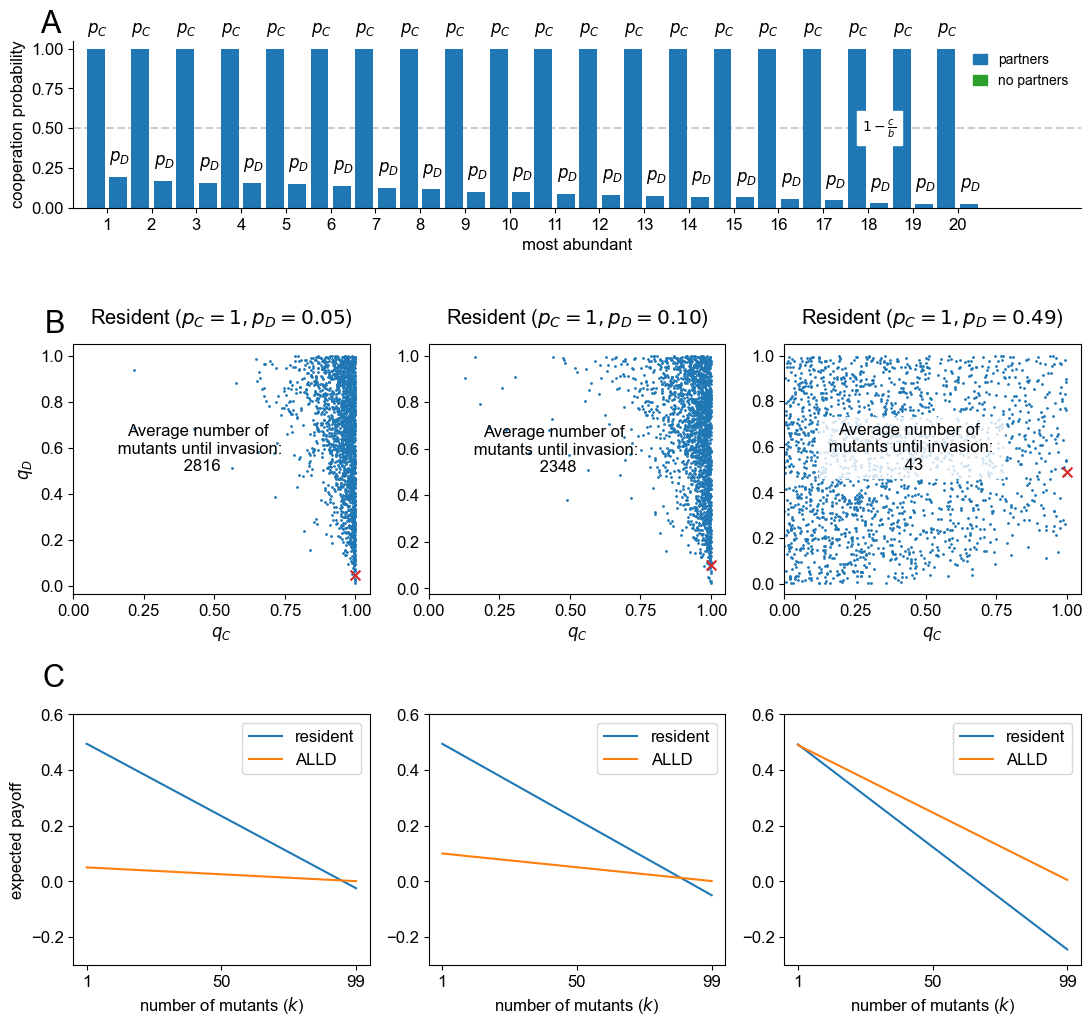

In [46]:
colors = ['tab:blue', 'tab:green']

fig, axes = plt.subplot_mosaic("AAA;...;BCD;...;EFG", figsize=(13, 12),
                               gridspec_kw = {'height_ratios':[1, .2, 1.5,.1, 1.5]})

j = 0

for i, row in top_one_coop.iterrows():
    if row['ispartner'] == True:
        c = colors[0]
    else:
        c = colors[1]
        
    axes["A"].bar([j + 0, j + 1], [row['p_1'], row['p_2']], color=c)
    
    axes["A"].text(j + 0 - .4, row['p_1'] + .1, "$p_{C}$")
    
    axes["A"].text(j + 1 - .4, row['p_2'] + .1, "$p_{D}$")
    
    j += 2
    
axes["A"].axhline(0.5, linestyle='--', color='black', alpha=.2, zorder=-1)

axes["A"].text(35, 0.5, r'$1 - \frac{c}{b}$',
               fontsize=10, va='center', ha='center', backgroundcolor='w');

axes["A"].set_xticks(np.arange(0.5, 40, 2))
axes["A"].set_xticklabels(np.arange(1, 21, 1))
axes["A"].set_xlabel("most abundant")
axes["A"].set_ylabel("cooperation probability")
axes["A"].set_xlim(-1, 44)

label = [
        (
            mpatches.Patch(color='tab:blue'),
            f"partners",
        ),
        (
            mpatches.Patch(color='tab:green'),
            f"no partners",
        )
    ]

axes["A"].legend(
    *zip(*label),
#         bbox_to_anchor=(1.03, 1.01),
    handlelength=1,
    fontsize=10,
    frameon=False,
)

axes["A"].text(-2.5, 1.1, "A", fontsize=22
)


axes["A"].spines[['right', 'top']].set_visible(False)



axes["B"].scatter(invaders["p"], invaders["q"], s=1);
axes["B"].scatter(1, 0.05, s=50, marker='x', color='tab:red');
axes["B"].set_title("Resident ($p_{C} = 1, p_{D} = 0.05$)", y=1.05);
axes["B"].text(0.45, .5,
               f'Average number of \n mutants until invasion: \n {round(m1)}',
               ha='center')


axes["B"].text(-.1, 1.1, "B", fontsize=22
)


axes["C"].scatter(invaders2["p"], invaders2["q"], s=1);
axes["C"].scatter(1, 0.10, s=50, marker='x', color='tab:red');
axes["C"].set_title("Resident ($p_{C} = 1, p_{D} = 0.10$)", y=1.05);
axes["C"].text(0.45, .5,
               f'Average number of \n mutants until invasion: \n {round(m2)}',
               ha='center')

axes["D"].scatter(invaders1["p"], invaders1["q"], s=1);
axes["D"].scatter(1, 0.49, s=50, marker='x', color='tab:red');
axes["D"].set_title("Resident ($p_{C} = 1, p_{D} = 0.49$)", y=1.05);
t = axes["D"].text(0.45, .5,
               f'Average number of \n mutants until invasion: \n {round(m3)}',
               ha='center')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))


axes["E"].plot(range(1, N), payoffsR, label='resident');
axes["E"].plot(range(1, N), payoffsM, label='ALLD');

axes["E"].text(-15, .7, "C", fontsize=22
)

axes["F"].plot(range(1, N), payoffsR2, label='resident');
axes["F"].plot(range(1, N), payoffsM2, label='ALLD');

axes["G"].plot(range(1, N), payoffsR3, label='resident');
axes["G"].plot(range(1, N), payoffsM3, label='ALLD');

axes["E"].set_ylabel("expected payoff");
axes["B"].set_ylabel("$q_{D}$");

for letter in ["B", "C", "D"]:
    axes[letter].set_xlabel("$q_{C}$");
    axes[letter].set_xlim(0, 1.05)
    

for letter in ["E", "F", "G"]:

    axes[letter].set_xlabel("number of mutants ($k$)");
    axes[letter].set_xticks([1, 50, 99])
    axes[letter].set_ylim(-0.3, 0.6)

    axes[letter].legend();

fig.subplots_adjust(hspace=.36)

fig.savefig("../figures/siFigInvasionR1.pdf", bbox_inches="tight")

## Reactive - 2

In the reactive-2 case we see that $p_{DC}$ is higher than $p_{CD}$, why is that?

In [36]:
p_prime_player = [0.99, 0.6, 0.1, 0.3]

p_player = [0.99, 0.1, 0.6, 0.3]

In [37]:
q1, q2, q3, q4 = sym.symbols("q_1, q_2, q_3, q_4")

b, c = sym.symbols("b, c")

coplayer = [q1, q2, q3, q4]

In [38]:
expr1 = match_payoffs_efficiently(p_player, coplayer, b, c, True)

In [39]:
expr2 = match_payoffs_efficiently(p_prime_player, coplayer, b, c, True)

In [33]:
expr1.factor() - expr2.factor()

AttributeError: 'tuple' object has no attribute 'factor'

In [34]:
b, c = 1, .5

Sx = np.array([b - c, -c, b, 0] * 4)

Sy = np.array([b - c, b, -c, 0] * 4)

In [35]:
player = p_player

mem2_player = [player[0], player[1], player[0], player[1],
               player[2], player[3], player[2], player[3]] * 2

np.random.seed(1)

X, Y = [], []

for _ in range(10**4):
    
    coplayer = np.random.random(16)
#     q1, q2, q3, q4 = np.random.random(4)
    
#     coplayer = [q1, q1, q2, q2,
#                 q1, q1, q2, q2,
#                 q3, q3, q4, q4,
#                 q3, q3, q4, q4]
#     coplayer = [q1, q2, q1, q2, q3, q4, q3, q4] * 2
    

    payoffs_p1, payoffs_p2 = match_payoffs(mem2_player, coplayer, Sx, Sy, memory='two')

    X.append(payoffs_p1)
    Y.append(payoffs_p2)

In [36]:
player = p_prime_player

mem2_player = [player[0], player[1], player[0], player[1],
               player[2], player[3], player[2], player[3]] * 2

np.random.seed(1)

X1, Y1 = [], []

for _ in range(10**4):
    
    coplayer = np.random.random(16)
#     q1, q2, q3, q4 = np.random.random(4)
    
# #     coplayer = [q1, q1, q2, q2,
# #                 q1, q1, q2, q2,
# #                 q3, q3, q4, q4,
# #                 q3, q3, q4, q4]

#     coplayer = [q1, q2, q1, q2, q3, q4, q3, q4] * 2
    
    

    payoffs_p1, payoffs_p2 = match_payoffs(mem2_player, coplayer, Sx, Sy, memory='two')

    X1.append(payoffs_p1)
    Y1.append(payoffs_p2)

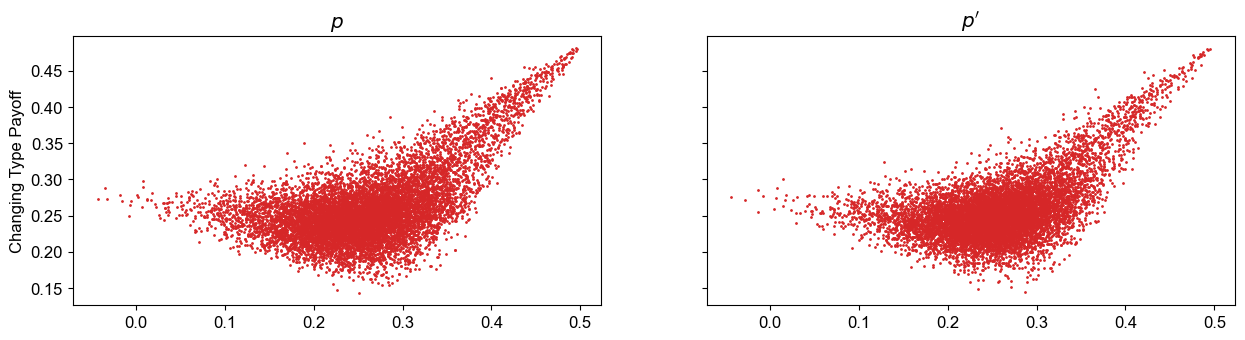

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 3.5), sharex=True, sharey=True)


axes[0].set_ylabel("Changing Type Payoff")

axes[0].scatter(X, Y, s=1, color="tab:red")
axes[0].set_title("$p$")

axes[1].scatter(X1, Y1, s=1, color="tab:red")
axes[1].set_title("$p'$");

In [38]:
columns = ["p_cc", 'p_cd', 'p_dc', 'p_dd', 't', 'coop']

invasion = pd.read_csv("../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_0.99_p2_0.1_p3_0.6_p4_0.3.csv",
                      names=columns)

invasion2 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_0.99_p2_0.6_p3_0.1_p4_0.3.csv",
                      names=columns)

In [39]:
invasion['t'].mean(), invasion2['t'].mean()

(892.6065393460653, 238.05439456054395)

In [56]:
p_player = [0.99, 0.6, 0.1, 0.3]

p_prime_player = [0.99, 0.1, 0.6, 0.3]

In [57]:
b, c = 1, .5

N = 100

Sx = np.array([b - c, -c, b, 0] * 4)

Sy = np.array([b - c, b, -c, 0] * 4)

memory = 'two'

In [58]:
AllD = [0, 0, 0, 0]

resident1 = p_player

resident2 = p_prime_player

In [59]:
pRM1, pMR1 = match_payoffs_efficiently(resident1, AllD, b, c, False)

In [60]:
pRM2, pMR2 = match_payoffs_efficiently(resident2, AllD, b, c, False)

In [61]:
pRR1, _ = match_payoffs_efficiently(resident1, resident1, b, c, False)
pRR2, _ = match_payoffs_efficiently(resident2, resident2, b, c, False)

In [62]:
pMM, _ = match_payoffs_efficiently(AllD, AllD, b, c, False)

In [63]:
payoffsR = []; payoffsM = []

payoffsR2 = []; payoffsM2 = []


for k in (1, 99):

    pR, pM = expected_payoffs(pRR1, pRM1, pMR1, pMM, N, k, memory)

    payoffsR.append(pR)
    payoffsM.append(pM)

    pR2, pM2 = expected_payoffs(pRR2, pRM2, pMR2, pMM, N, k, memory)

    payoffsR2.append(pR2)
    payoffsM2.append(pM2)

TypeError: expected_payoffs() takes 6 positional arguments but 7 were given

In [ ]:
fig, axes = plt.subplots()

axes.plot(payoffsR, label='$\pi_{R}$');

axes.plot(payoffsM, label='$\pi_{M}$');


axes.plot(payoffsR2, ':', label="$\pi^{'}_{R}$", color='black');

axes.plot(payoffsM2, ':', color='red', label="$\pi^{''}_{M}$");

# axes[i].set_title(mutant)

axes.legend();

## In the reactive-space how are they doing, payoff wise?

In [41]:
pure_s = list(itertools.product([0, 1], repeat=4))

In [255]:
p_player, p_prime_player

([1, 0.6, 0.1, 0.3], [1, 0.1, 0.6, 0.3])

In [ ]:
for coplayer in pure_s:
    
    p_player_mem2 = [p_player[0], p_player[1], p_player[0], p_player[1],
                     p_player[2], p_player[3], p_player[2], p_player[3]] * 2
    
    p_prime_player_mem2 = [p_prime_player[0], p_prime_player[1], p_prime_player[0], p_prime_player[1],
                           p_prime_player[2], p_prime_player[3], p_prime_player[2], p_prime_player[3]] * 2
    
    coplayer_mem2 = [coplayer[0], coplayer[1], coplayer[0], coplayer[1],
                     coplayer[2], coplayer[3], coplayer[2], coplayer[3]] * 2
    
    M1 = repeated_play.transition_matrix_repeated_game(p_player_mem2, coplayer_mem2)
    
    ss1 = repeated_play.stationary_distribution(M1)[0]
    
    M2 = repeated_play.transition_matrix_repeated_game(p_player_mem2, coplayer_mem2)
    
    ss12 = repeated_play.stationary_distribution(M1)[0]

In [ ]:


expected_payoffs(payoffRR, payoffRM, payoffMR, payoffMM, N, k, memory):

In [214]:
N = 100; b = 1; c = 1/2

memory = "two"

resident1 = p_player

resident2 = p_prime_player

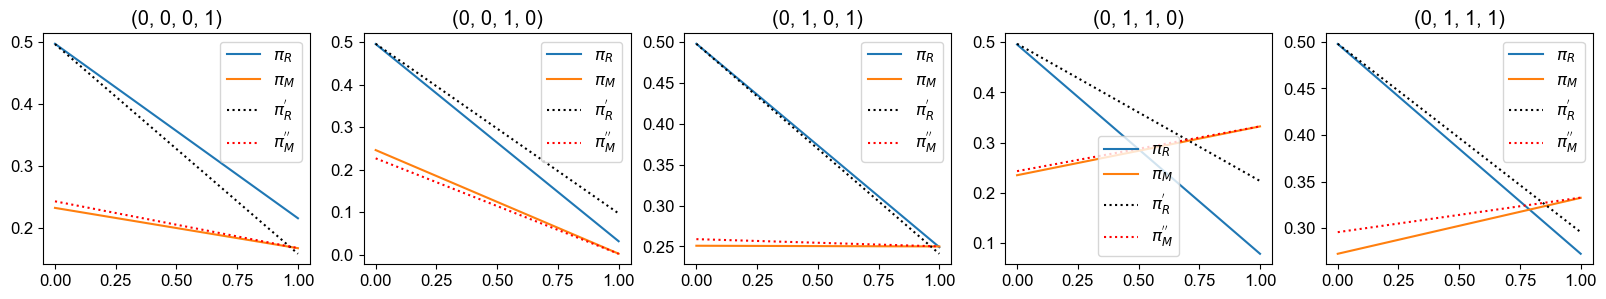

In [485]:
fig, axes = plt.subplots(ncols=5, figsize=(20, 3
                                ))

for i, index in enumerate(deviating_indices):

    mutant = pure[index]

    payoffsR = []; payoffsM = []

    payoffsR2 = []; payoffsM2 = []


    for k in (1, 99):

        pR, pM = expected_payoffs(resident1, mutant, b, c, N, k, memory)

        payoffsR.append(pR)
        payoffsM.append(pM)

        pR2, pM2 = expected_payoffs(resident2, mutant, b, c, N, k, memory)

        payoffsR2.append(pR2)
        payoffsM2.append(pM2)

    axes[i].plot(payoffsR, label='$\pi_{R}$');

    axes[i].plot(payoffsM, label='$\pi_{M}$');

    axes[i].plot(payoffsR2, ':', label="$\pi^{'}_{R}$", color='black');

    axes[i].plot(payoffsM2, ':', color='red', label="$\pi^{''}_{M}$");
    
    axes[i].set_title(mutant)

    axes[i].legend();

## The data

In [89]:
two_df = reactive_abundant[reactive_abundant['type'] == 'two']

In [90]:
ispartner = []

for i, row in tqdm(two_df.iterrows()):
    condition = is_partner_two_bits(row["p_1"], row["p_2"], row["p_3"], row["p_4"], 1/2, 1)

    ispartner.append(condition)

0it [00:00, ?it/s]

In [91]:
len(ispartner), len(two_df)

(877409, 877409)

In [92]:
two_df['ispartner'] = ispartner

### Top from coop

In [93]:
groups = two_df.groupby('seed')

groups_coop = two_df[(two_df["p_1"] > 0.95)].groupby("seed")
    
top = []

top_coop = []

for i, group in groups:
    top.append(group.sort_values('frequencies').iloc[-1])
    
for i, group in groups_coop:
    top_coop.append(group.sort_values('frequencies').iloc[-1])

In [94]:
top_two = pd.DataFrame(top)

top_two['p_1'] = top_two['p_1'].round(2)

top_two = top_two.sort_values(['p_1', 'p_2', 'p_3', 'p_4'], ascending=False)

top_two = top_two.reset_index(drop=True)

In [95]:
top_two_coop = pd.DataFrame(top_coop)

top_two_coop['p_1'] = top_two_coop['p_1'].round(2)

top_two_coop = top_two_coop.sort_values(['p_1', 'p_2', 'p_3', 'p_4'], ascending=False)

top_two_coop = top_two_coop.reset_index(drop=True)

In [96]:
columns = ["p_cc", 'p_cd', 'p_dc', 'p_dd', 't', 'coop']

invasion = pd.read_csv("../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_0.99_p2_0.1_p3_0.6_p4_0.3.csv",
                      names=columns)

invasion2 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_0.99_p2_0.6_p3_0.1_p4_0.3.csv",
                      names=columns)

In [97]:
invasion['t'].mean(), invasion2['t'].mean()

(892.6065393460653, 238.05439456054395)

In [98]:
p_player = [0.99, 0.1, 0.6, 0.3]

p_prime_player = [0.99, 0.6, 0.1, 0.3]

In [100]:
p_player_mem = [p_player[0], p_player[1], p_player[0], p_player[1],
                p_player[2], p_player[3], p_player[2], p_player[3]] * 2


In [101]:
p_prime_player_mem = [p_prime_player[0], p_prime_player[1], p_prime_player[0], p_prime_player[1],
                      p_prime_player[2], p_prime_player[3], p_prime_player[2], p_prime_player[3]] * 2

In [102]:
b, c = 1, .5

N = 100

Sx = np.array([b - c, -c, b, 0] * 4)

Sy = np.array([b - c, b, -c, 0] * 4)

memory = 'two'

In [103]:
match_payoffs(p_player_mem, p_player_mem, Sx, Sy, memory='two')

(0.40050046518990795, 0.40050046518990795)

In [104]:
match_payoffs(p_prime_player_mem, p_prime_player_mem, Sx, Sy, memory='two')

(0.33798502057898233, 0.3379850205789822)

In [105]:
AllD = [0, 0, 0, 0]

resident1 = p_player

resident2 = p_prime_player

In [106]:
pRM1, pMR1 = match_payoffs_efficiently(resident1, AllD, b, c, False)

In [107]:
pRM2, pMR2 = match_payoffs_efficiently(resident2, AllD, b, c, False)

In [108]:
pRR1, _ = match_payoffs_efficiently(resident1, resident1, b, c, False)
pRR2, _ = match_payoffs_efficiently(resident2, resident2, b, c, False)

In [109]:
pMM, _ = match_payoffs_efficiently(AllD, AllD, b, c, False)

In [110]:
pRR1, pRR2

(0.46923076923076923, 0.4125000000000004)

In [111]:
resident1

[0.99, 0.1, 0.6, 0.3]

In [112]:
b, c = 1, .5

N = 100

Sx = np.array([b - c, -c, b, 0])

Sy = np.array([b - c, b, -c, 0])

In [115]:
# match_payoffs(resident1 * 2, resident1 * 2, Sx, Sy, memory=2)

In [116]:
payoffsR = []; payoffsM = []

payoffsR2 = []; payoffsM2 = []


for k in range(1, N):

    pR, pM = expected_payoffs(pRR1, pRM1, pMR1, pMM, N, k)

    payoffsR.append(pR)
    payoffsM.append(pM)

    pR2, pM2 = expected_payoffs(pRR2, pRM2, pMR2, pMM, N, k)

    payoffsR2.append(pR2)
    payoffsM2.append(pM2)

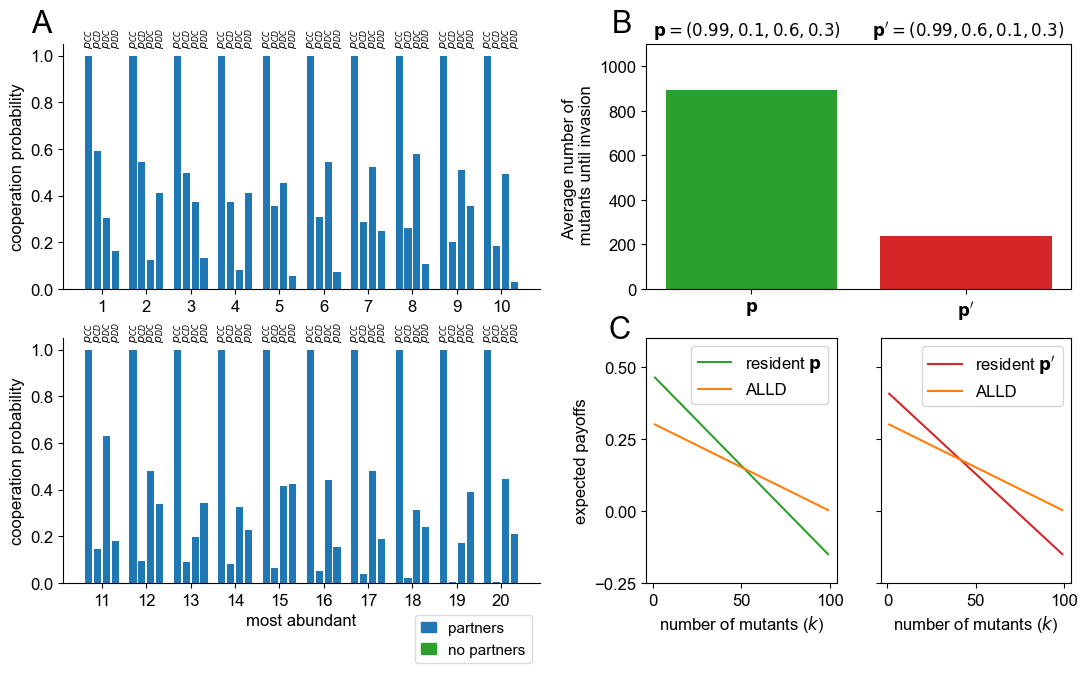

In [190]:
colors = ['tab:blue', 'tab:green']

fig, axes = plt.subplot_mosaic("A.CC;B.DE", figsize=(13, 7), 
                               gridspec_kw = {'width_ratios':[2.5, .1, 1, 1]})


j = 0

for i, row in top_two_coop.iterrows():
    if row['ispartner'] == True:
        c = colors[0]
    else:
        c = colors[1]
        
    if i < 10:
        axes["A"].bar([j + 0, j + 1, j + 2, j + 3],
                      [row['p_1'],
                       row['p_2'],
                       row['p_3'],
                       row['p_4']], color=c)
        
        
        axes["A"].text(j + 0 - .6, row['p_1'] + .05, "$p_{CC}$", fontsize=8, rotation=90)
        axes["A"].text(j + 1 - .6, row['p_1'] + .05, "$p_{CD}$", fontsize=8, rotation=90)
        axes["A"].text(j + 2 - .6, row['p_1'] + .05, "$p_{DC}$", fontsize=8, rotation=90)
        axes["A"].text(j + 3 - .6, row['p_1'] + .05, "$p_{DD}$", fontsize=8, rotation=90)
    
    if i == 10:
        j = 0
    if i >= 10:
        
        axes["B"].bar([j + 0, j + 1, j + 2, j + 3],
                      [row['p_1'], row['p_2'], row['p_3'], row['p_4']], color=c)
        
        axes["B"].text(j + 0 - .6, row['p_1'] + .05, "$p_{CC}$", fontsize=8, rotation=90)
        axes["B"].text(j + 1 - .6, row['p_1'] + .05, "$p_{CD}$", fontsize=8, rotation=90)
        axes["B"].text(j + 2 - .6, row['p_1'] + .05, "$p_{DC}$", fontsize=8, rotation=90)
        axes["B"].text(j + 3 - .6, row['p_1'] + .05, "$p_{DD}$", fontsize=8, rotation=90)
    
    
    j += 5
    
    
axes["A"].text(-6.5, 1.1, "A", fontsize=22
)


axes["A"].spines[['right', 'top']].set_visible(False)
axes["B"].spines[['right', 'top']].set_visible(False)
    
axes["C"].bar([0, 1], [invasion['t'].mean(), invasion2['t'].mean()], color=["tab:green", "tab:red"])
axes["C"].set_ylim(0, 10 ** 3)

axes["C"].set_ylabel("Average number of \n mutants until invasion")
axes["C"].set_xticks([0, 1], labels=[r'$\mathbf{p}$', r"$\mathbf{p'}$"])

axes["D"].plot(range(1, N), payoffsR, label=r'resident $\mathbf{p}$', color='tab:green');
axes["D"].plot(range(1, N), payoffsM, label='ALLD', color='tab:orange');

axes["E"].plot(range(1, N), payoffsR2, label=r"resident $\mathbf{p'}$", color='tab:red');
axes["E"].plot(range(1, N), payoffsM2, label='ALLD', color='tab:orange');

for letter in ["D", "E"]:
    axes[letter].set_ylim(-.15, .6)
    axes[letter].set_xlabel("number of mutants ($k$)")
    axes[letter].legend();
    

axes["D"].set_yticks([-.25, 0, .25, .5])
axes["E"].set_yticks([-.25, 0, .25, .5], ["" for _ in range(4)])

axes['D'].text(-25, 0.6, "C", fontsize=22)

for letter in ["A", "B"]:
    axes[letter].set_xticks(np.arange(1.5, 50, 5))
    axes[letter].set_ylabel("cooperation probability")
    
axes["D"].set_ylabel("expected payoffs")

axes["A"].set_xticklabels(np.arange(1, 11, 1));
axes["B"].set_xticklabels(np.arange(11, 21, 1));

axes['C'].set_title(r"$\mathbf{p} = (0.99, 0.1, 0.6, 0.3) \qquad \mathbf{p'} = (0.99, 0.6, 0.1, 0.3)$",
                   fontsize=12)

axes['C'].set_ylim(0, 1100)
axes['C'].text(-.65, 1153, "B", fontsize=22)

label = [
        (
            mpatches.Patch(color='tab:blue'),
            f"partners",
        ),
        (
            mpatches.Patch(color='tab:green'),
            f"no partners",
        )
    ]

axes["B"].set_xlabel("most abundant");

axes["B"].legend(
    *zip(*label),
    handlelength=1,
    fontsize=11,
    facecolor='white',
    framealpha=.7,
    ncols=1, bbox_to_anchor=(1, -.1)
    
);


fig.savefig("../figures/siFigInvasionR2.pdf", bbox_inches="tight")

In [91]:
top_two['p_2'].mean(), top_two['p_3'].mean()

(0.1278183732675065, 0.6148137780499999)

In [251]:
top_two_coop['p_2'].mean(), top_two_coop['p_3'].mean()

(0.209806133706, 0.39395485888000004)

### Understanding the weird case n=2

In [230]:
import itertools

In [287]:
player1_evol_outcome = [1, 0.1, 0.6, 0.3]

player1_opposite = [1, 0.6, 0.1, 0.3]

In [295]:
A = match_payoffs_efficiently(player1_evol_outcome, [0, 0, 0, 1], 1, 1/2)

0.3333333333333335 0.3333333333333333


In [296]:

B = match_payoffs_efficiently(player1_opposite, [0, 0, 0, 1], 1, 1/2)

0.3333333333333335 0.3333333333333334


In [322]:
p1, p2, p3, p4 = sym.symbols("p1, p2, p3, p4")

In [382]:
coplayer = [1, 0, 0, 1]

M = trnsf_transition_m_memory_two(coplayer, analytical=False)

In [383]:
ss = repeated_play.stationary_distribution(M)[0]

In [384]:
ss

array([-0.        ,  0.33333333,  0.33333333,  0.33333333])

In [385]:
rho_q = ss[0] + ss[1]

In [386]:
rho_q

0.3333333333333335

In [387]:
ss[2]

0.3333333333333333

In [367]:
A[0]

0.3333333333333333

In [360]:
ss[2] + ss[3]

0.5

In [351]:
ss[1]

0.3333333333333335

In [293]:
pure = list(itertools.product([0, 1], repeat=4))

In [289]:
for coplayer in pure:
    A = match_payoffs_efficiently(player1_evol_outcome, coplayer, 1, 1/2)
    
    B = match_payoffs_efficiently(player1_opposite, coplayer, 1, 1/2)
    
    if A != B:
        print(coplayer, A, B)

(0, 0, 0, 1) 0.16666666666666657 0.16666666666666669
(0, 0, 1, 1) 0.25 0.2500000000000001
(0, 1, 1, 0) 0.23333333333333345 0.23333333333333334
(0, 1, 1, 1) 0.23333333333333345 0.23333333333333334
(1, 0, 0, 1) 0.16666666666666657 0.16666666666666669


In [242]:
for coplayer in pure:
    A = match_payoffs_efficiently(player1_evol_outcome, coplayer, 1, 1/3)
    
    B = match_payoffs_efficiently(player1_opposite, coplayer, 1, 1/3)
    
    if A != B:
        print(coplayer, A, B)

(0, 0, 0, 1) 0.2055555555555555 0.2055555555555556
(0, 0, 1, 1) 0.32083333333333336 0.3208333333333334
(1, 0, 0, 1) 0.2055555555555555 0.2055555555555556


In [481]:
N = 100; b = 1; c = 1/2

memory = "two"

resident1 = player1_evol_outcome

resident2 = player1_opposite

deviating_indices = [1, 2, 5, 6, 7]

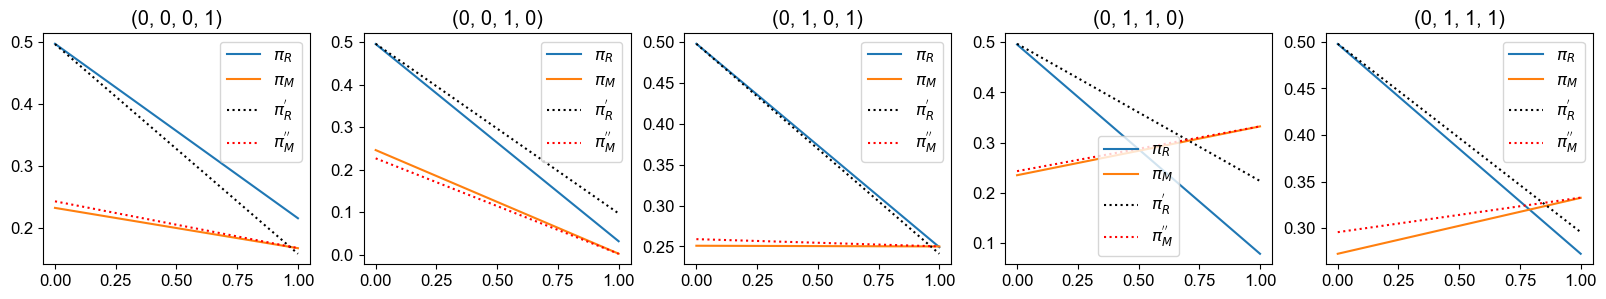

In [485]:
fig, axes = plt.subplots(ncols=5, figsize=(20, 3
                                ))

for i, index in enumerate(deviating_indices):

    mutant = pure[index]

    payoffsR = []; payoffsM = []

    payoffsR2 = []; payoffsM2 = []


    for k in (1, 99):

        pR, pM = expected_payoffs(resident1, mutant, b, c, N, k, memory)

        payoffsR.append(pR)
        payoffsM.append(pM)

        pR2, pM2 = expected_payoffs(resident2, mutant, b, c, N, k, memory)

        payoffsR2.append(pR2)
        payoffsM2.append(pM2)

    axes[i].plot(payoffsR, label='$\pi_{R}$');

    axes[i].plot(payoffsM, label='$\pi_{M}$');

    axes[i].plot(payoffsR2, ':', label="$\pi^{'}_{R}$", color='black');

    axes[i].plot(payoffsM2, ':', color='red', label="$\pi^{''}_{M}$");
    
    axes[i].set_title(mutant)

    axes[i].legend();

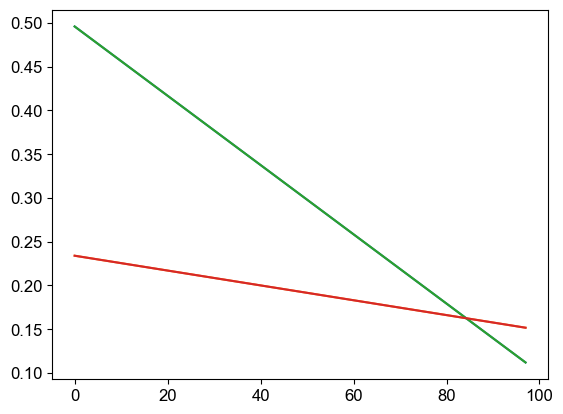

In [493]:
plt.plot([expected_payoffs(resident1, [0.3, .3, .3, .3], b, c, N, i, memory) for i in range(1, 99)]);

plt.plot([expected_payoffs(resident2, [0.3, .3, .3, .3], b, c, N, i, memory) for i in range(1, 99)]);

In [269]:
def expected_payoffs(p1, p2, b, c, N, k, memory):
    
    if memory == "two":
    
        Sx = np.array([b - c, -c, b, 0] * 4)

        Sy = np.array([b - c, b, -c, 0] * 4)

        player = [p1[0], p1[1], p1[0], p1[1],
                  p1[2], p1[3], p1[2], p1[3]] * 2

        coplayer = [p2[0], p2[1], p2[0], p2[1],
                    p2[0], p2[1], p2[0], p2[1],
                    p2[2], p2[3], p2[2], p2[3],
                    p2[2], p2[3], p2[2], p2[3]]
        
    if memory == "one":
    
        Sx = np.array([b - c, -c, b, 0])

        Sy = np.array([b - c, b, -c, 0])

        player = [p1[0], p1[1], p1[0], p1[1]]

        coplayer = [p2[0], p2[0], p2[1], p2[1]]
    
    payoffRM, payoffMR = match_payoffs(player, coplayer, Sx, Sy, memory=memory)
        
    payoffMM, _ = match_payoffs(coplayer, coplayer, Sx, Sy, memory=memory)
    
    payoffRR, _ = match_payoffs(player, player, Sx, Sy, memory=memory)
    
    expected_R = ((N - k - 1) / (N - 1)) * payoffRR + (k / (N - 1)) * payoffRM
    
    expected_M = ((N - k) / (N - 1)) * payoffMR + ((k - 1) / (N - 1)) * payoffMM
    
    return expected_R, expected_M

### Evolution over Seeds

In [23]:
def one_bit_condition_one(p1, p2, c, b):
    return p2 < 1 - c / b


def one_bit_condition_two(p1, p2, c, b):
    return p1 > 0.95


def is_partner_one_bit(p1, p2, c, b):
    return (one_bit_condition_one(p1, p2, c, 1)) and (
        one_bit_condition_two(p1, p2, c, 1)
    )

In [24]:
def two_bit_condition_one(p1, p2, p3, p4, c, b):
    return p4 < (1 - c / b)


def two_bit_condition_two(p1, p2, p3, p4, c, b):
    return p2 + p3 < (2 - c / b)


def two_bit_condition_three(p1, p2, p3, p4, c, b):
    return p1 > 0.95


def is_partner_two_bits(p1, p2, p3, p4, c, b):
    return (
        (two_bit_condition_one(p1, p2, p3, p4, c, 1))
        and two_bit_condition_two(p1, p2, p3, p4, c, 1)
        and two_bit_condition_three(p1, p2, p3, p4, c, 1)
    )

In [25]:
reactive_abundant = pd.read_csv(
    "../prc_data/evolution_over_seeds_reactive_new.csv", index_col=0
)

In [26]:
dists = []

reactive = []


for type_, variables in zip(
    ["one", "two", "three"],
    [
        ["p_1", "p_2", "frequencies"],
        ["p_1", "p_2", "p_3", "p_4", "frequencies"],
        ["p_1", "p_2", "p_3", "p_4", "p_5", "p_6", "p_7", "p_8", "frequencies"],
    ],
):
    groups = reactive_abundant[
        (reactive_abundant["type"] == type_) & (reactive_abundant["p_1"] > 0.95)
    ].groupby("seed")

    per_seed = []

    for _, group in groups:
        index = group["frequencies"].idxmax()
        per_seed.append(tuple(group[group.index == index][variables].values[0]))

    ps = list(zip(*per_seed))

    reactive.append(ps[:-1])
    
dists.append(reactive)

In [27]:
spacing = np.linspace(-0.1, 0.1, 20)

evens = np.arange(1, 17, 1)

In [28]:
colors_dic = {
    "R1": "tab:orange",
    "R2": "tab:green",
    "R3": "tab:blue",
    "R4": "chocolate",
    "R5": "yellowgreen",
    "R6": "dodgerblue",
}

colors = [
    "tab:orange",
    "tab:green",
    "tab:blue",
    "chocolate",
    "yellowgreen",
    "dodgerblue",
]

linestyles = ["-o", "--o", ":o"]

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))

for j, dist in enumerate(dists[0]):
    averages = np.mean(dist, axis=1)


    for l, data in enumerate(dist):
        for l2, point in enumerate(data):
            _ = axes[j].scatter(
                0 + evens[l] + spacing[l2],
                point,
                color=colors_dic[f"R{j + 1}"],
                s=7,
                zorder=2,
            )
        _ = axes[j].bar(
            evens[l],
            averages[l],
            color=colors_dic[f"R{j + 1}"],
            alpha=0.5,)
        
        
    if j == 0:
        axes[j].set_ylabel("Cooperation Probability", fontweight="normal")

        axes[j].set_xticks([1, 2])
        axes[j].set_xticklabels(["$p_C$", "$p_D$"], rotation=45, fontsize=13)
    if j == 1:
        axes[j].set_xticks([1, 2, 3, 4])
        axes[j].set_xticklabels(
            ["$p_{CC}$", "$p_{CD}$", "$p_{DC}$", "$p_{DD}$"],
            rotation=45,
            fontsize=13,
        )
    if j == 2:
        axes[j].set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
        axes[j].set_xticklabels(
            [
                "$p_{CCC}$",
                "$p_{CCD}$",
                "$p_{CDC}$",
                "$p_{CDD}$",
                "$p_{DCC}$",
                "$p_{DCD}$",
                "$p_{DDC}$",
                "$p_{DDD}$",
            ],
            rotation=45,
            fontsize=13,
        )
        
    label = [
            (
                mpatches.Patch(color=colors_dic[f"R{j + 1}"]),
                f"$n={j + 1}$",
            )
        ]

    axes[j].legend(
        *zip(*label),
#         bbox_to_anchor=(1.03, 1.01),
        handlelength=1,
        fontsize=12,
        frameon=False,
    )
    
axes[0].text(-.25, 0.13,
               "Reactive strategies",
               rotation=90, fontsize=14,
               fontweight='bold')

fig.savefig("../figures/siFig3AbundantStrategies.pdf", bbox_inches="tight")

In [26]:
one_df = reactive_abundant[reactive_abundant['type'] == 'one']

In [27]:
ispartner = []

for i, row in tqdm(one_df.iterrows()):
    condition = is_partner_one_bit(row["p_1"], row["p_2"], 1/2, 1)

    ispartner.append(condition)

0it [00:00, ?it/s]

In [28]:
len(ispartner), len(one_df)

(792110, 792110)

In [29]:
one_df['ispartner'] = ispartner

In [30]:
groups = one_df.groupby('seed')

top = []

for i, group in groups:
    top.append(group.sort_values('frequencies').iloc[-1])

In [31]:
top_one = pd.DataFrame(top)

In [32]:
top_one['p_1'] = top_one['p_1'].round(2)

In [128]:
top_one = top_one.sort_values(['p_1', 'p_2'], ascending=False)

In [129]:
invaders = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.05.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [130]:
invaders1 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.49.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [131]:
invaders2 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.1.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [132]:
m1, m2, m3 = invaders['num'].mean(), invaders2['num'].mean(), invaders1['num'].mean(),

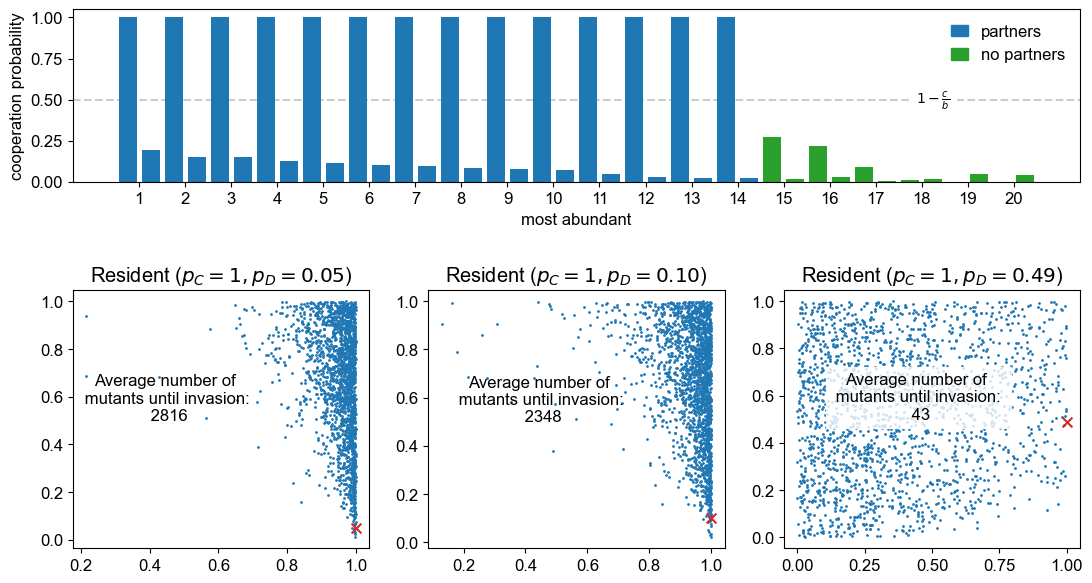

In [133]:
colors = ['tab:blue', 'tab:green']

fig, axes = plt.subplot_mosaic("AAA;BCD", figsize=(13, 7), gridspec_kw = {'height_ratios':[1, 1.5]})

j = 0

for i, row in top_one.iterrows():
    if row['ispartner'] == True:
        c = colors[0]
    else:
        c = colors[1]
        
    axes["A"].bar([j + 0, j + 1], [row['p_1'], row['p_2']], color=c)
    
    j += 2
    
axes["A"].axhline(0.5, linestyle='--', color='black', alpha=.2, zorder=-1)

axes["A"].text(35, 0.5, r'$1 - \frac{c}{b}$',
               fontsize=10, va='center', ha='center', backgroundcolor='w');

axes["A"].set_xticks(np.arange(0.5, 40, 2))
axes["A"].set_xticklabels(np.arange(1, 21, 1))
axes["A"].set_xlabel("most abundant")
axes["A"].set_ylabel("cooperation probability")

label = [
        (
            mpatches.Patch(color='tab:blue'),
            f"partners",
        ),
        (
            mpatches.Patch(color='tab:green'),
            f"no partners",
        )
    ]

axes["A"].legend(
    *zip(*label),
#         bbox_to_anchor=(1.03, 1.01),
    handlelength=1,
    fontsize=12,
    frameon=False,
)



axes["B"].scatter(invaders["p"], invaders["q"], s=1);
axes["B"].scatter(1, 0.05, s=50, marker='x', color='tab:red');
axes["B"].set_title("Resident ($p_{C} = 1, p_{D} = 0.05$)");
axes["B"].text(0.45, .5,
               f'Average number of \n mutants until invasion: \n {round(m1)}',
               ha='center')

axes["C"].scatter(invaders2["p"], invaders2["q"], s=1);
axes["C"].scatter(1, 0.10, s=50, marker='x', color='tab:red');
axes["C"].set_title("Resident ($p_{C} = 1, p_{D} = 0.10$)");
axes["C"].text(0.45, .5,
               f'Average number of \n mutants until invasion: \n {round(m2)}',
               ha='center')

axes["D"].scatter(invaders1["p"], invaders1["q"], s=1);
axes["D"].scatter(1, 0.49, s=50, marker='x', color='tab:red');
axes["D"].set_title("Resident ($p_{C} = 1, p_{D} = 0.49$)");
t = axes["D"].text(0.45, .5,
               f'Average number of \n mutants until invasion: \n {round(m3)}',
               ha='center')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

fig.subplots_adjust(hspace=.5)

fig.savefig("../figures/siFigInvasionR1.pdf", bbox_inches="tight")

In [282]:
N = 100

b = 1

c = 1/2

memory = "one"

resident = [1, 0.48]

mutant = [0, 0]

payoffsR = []

payoffsM = []


for k in (1, 99):
    
    pR, pM = expected_payoffs(resident, mutant, b, c, N, k, memory)
    
    payoffsR.append(pR)
    payoffsM.append(pM)

In [283]:
expected_payoffs(resident, mutant, b, c, N, 1, memory)

(0.49252525252525253, 0.48)

In [284]:
(0.5 * 99 + 0 * 1) / 100

0.495

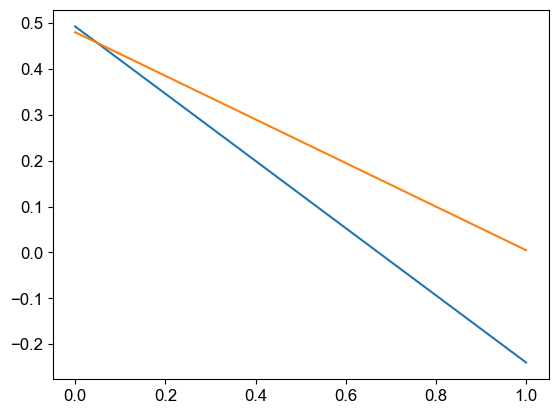

In [285]:
plt.plot(payoffsR, label='$\pi_{R}$');

plt.plot(payoffsM, label='$\pi_{R}$');

## Reactive-2 

In [134]:
two_df = reactive_abundant[reactive_abundant['type'] == 'two']

In [135]:
ispartner = []

for i, row in tqdm(two_df.iterrows()):
    
    condition = is_partner_two_bits(
        row["p_1"], row["p_2"], row["p_3"], row["p_4"], 1/2, 1
    )
    ispartner.append(condition)

0it [00:00, ?it/s]

In [136]:
len(ispartner), len(two_df)

(877409, 877409)

In [137]:
two_df['ispartner'] = ispartner

**How many top are partners?**

In [138]:
groups = two_df.groupby('seed')

count = []
top_s = []

for i, group in groups:
    count.append(group.sort_values('frequencies').iloc[-1]['ispartner'])
    
    top_s.append(group.sort_values('frequencies').iloc[-1][['p_1', 'p_2', 'p_3', 'p_4', 'ispartner']])

In [139]:
len(count), sum(count)

(20, 13)

In [140]:
top_two = pd.DataFrame(top_s)

In [141]:
top_two['p_1'] = top_two['p_1'].round(2)

In [142]:
top_two = top_two.sort_values(['p_1', 'p_2', 'p_3', 'p_4'], ascending=False)

In [143]:
top_two = top_two.reset_index()

**Invasion**

In [439]:
files = ['../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.05_p3_0.6_p4_0.1.csv',
 '../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.6_p3_0.05_p4_0.1.csv']

In [440]:
invaders = [pd.read_csv(file,
                       header=None, names=["p1", "p2", "p3", "p4", "num", "coop"]) for file in files]

In [441]:
invaders[0]['num'].mean(), invaders[1]['num'].mean()

(14635.5004995005, 15212.784215784215)

In [442]:
invaders[0]

,p1,p2,p3,p4,num,coop
0,1.000000,0.050000,0.600000,0.100000,0,0.000000
1,0.976101,0.476680,0.912576,0.793678,3476,0.948824
2,0.985954,0.908740,0.698869,0.412776,1368,0.977529
3,0.952704,0.394473,0.755102,0.907765,25260,0.874360
4,0.989817,0.868745,0.512118,0.463805,33337,0.975054
...,...,...,...,...,...,...
996,0.983334,0.554146,0.949907,0.537171,46006,0.969035
997,0.997312,0.905407,0.460373,0.700582,3613,0.993126
998,0.992061,0.572293,0.926411,0.482104,3427,0.984531
999,0.994461,0.964535,0.839823,0.068530,7422,0.993120


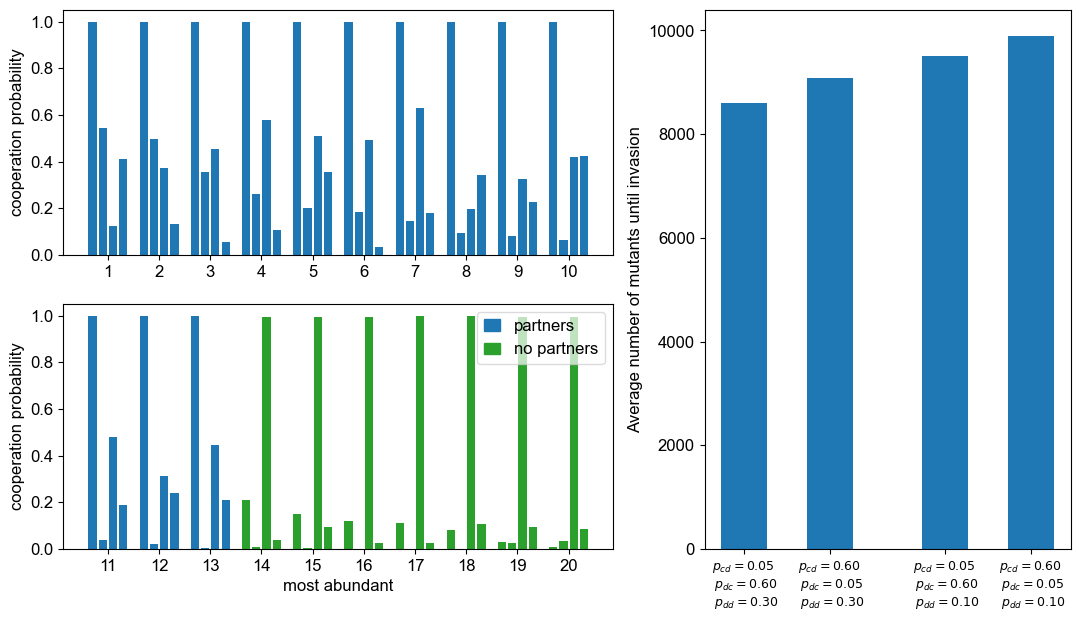

In [174]:
colors = ['tab:blue', 'tab:green']

fig, axes = plt.subplot_mosaic("AC;BC", figsize=(13, 7), gridspec_kw = {'width_ratios':[1.5, 1]})


j = 0

for i, row in top_two.iterrows():
    if row['ispartner'] == True:
        c = colors[0]
    else:
        c = colors[1]
        
    if i < 10:
        
        axes["A"].bar([j + 0, j + 1, j + 2, j + 3],
                      [row['p_1'],
                       row['p_2'],
                       row['p_3'],
                       row['p_4']], color=c)
    
    if i == 10:
        j = 0
    if i >= 10:
        
        axes["B"].bar([j + 0, j + 1, j + 2, j + 3],
                      [row['p_1'], row['p_2'], row['p_3'], row['p_4']], color=c)
    
    j += 5
    
for letter in ["A", "B"]:
    axes[letter].set_xticks(np.arange(1.5, 50, 5))
    axes[letter].set_ylabel("cooperation probability")

axes["A"].set_xticklabels(np.arange(1, 11, 1));
axes["B"].set_xticklabels(np.arange(11, 21, 1));


label = [
        (
            mpatches.Patch(color='tab:blue'),
            f"partners",
        ),
        (
            mpatches.Patch(color='tab:green'),
            f"no partners",
        )
    ]

axes["B"].set_xlabel("most abundant");

axes["B"].legend(
    *zip(*label),
#         bbox_to_anchor=(1.03, 1.01),
    handlelength=1,
    fontsize=12,
    facecolor='white',
    framealpha=.7
)

bars = [inv['num'].median() for inv in invaders]


axes["C"].bar([0, 1.5, 3.5, 5], bars);
axes["C"].set_xticks([0, 1.5, 3.5, 5], ['$p_{cd}=0.05$ \n $p_{dc}=0.60$ \n $p_{dd}=0.30$',
                                    '$p_{cd}=0.60$ \n $p_{dc}=0.05$ \n $p_{dd}=0.30$',
                                    '$p_{cd}=0.05$ \n $p_{dc}=0.60$ \n $p_{dd}=0.10$',
                                    '$p_{cd}=0.60$ \n $p_{dc}=0.05$ \n $p_{dd}=0.10$',], fontsize=9);

axes["C"].set_ylabel("Average number of mutants until invasion");


fig.savefig("../figures/siFigInvasionR2.pdf", bbox_inches="tight")

In [44]:
two_df = two_df.sort_values('frequencies')

In [49]:
top = two_df[two_df['frequencies'] > 6000]

In [55]:
p2s = two_df[two_df['ispartner'] == True]['p_2']
p3s = two_df[two_df['ispartner'] == True]['p_3']
p4s = two_df[two_df['ispartner'] == True]['p_4']

In [64]:
two_df.head()

,p_1,p_2,t,cooperation,type,seed,frequencies,frequencies norm,p_3,p_4,p_5,p_6,p_7,p_8,ispartner
18033,0.720381,0.752551,4223626,0.616536,two,8,1,1.000000e-07,0.327872,0.610666,NaN,NaN,NaN,NaN,False
38980,0.682990,0.625866,9016003,0.698229,two,8,1,1.000000e-07,0.832754,0.632334,NaN,NaN,NaN,NaN,False
18942,0.129594,0.613381,4275486,0.279562,two,3,1,1.000000e-07,0.316952,0.156698,NaN,NaN,NaN,NaN,False
38947,0.522480,0.936188,9008131,0.479677,two,8,1,1.000000e-07,0.084193,0.331284,NaN,NaN,NaN,NaN,False
18954,0.811190,0.672196,4277743,0.509460,two,3,1,1.000000e-07,0.663229,0.033582,NaN,NaN,NaN,NaN,False


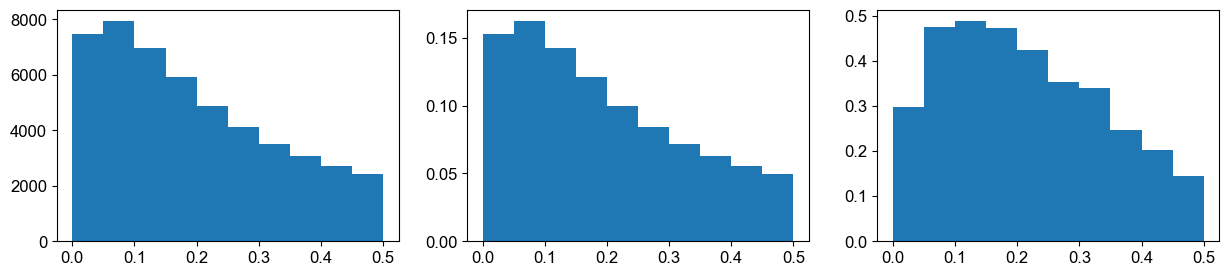

In [67]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 3))

ax[0].hist(p4s);

weights = np.ones_like(p4s) / len(p4s)

ax[1].hist(p4s, weights=weights);


ax[2].hist(p4s, weights=two_df[two_df['ispartner'] == True]['frequencies norm']);

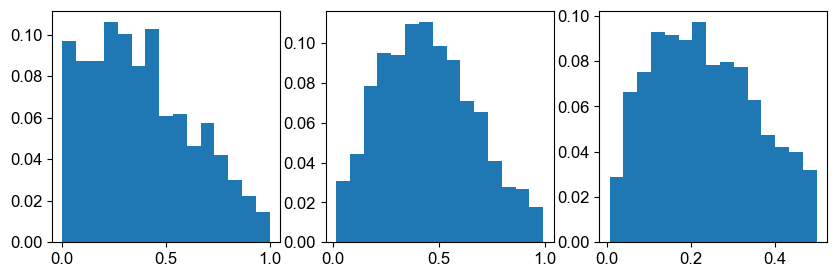

In [51]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 3))

weights = np.ones_like(p2s) / len(p2s)

h1 = axes[0].hist(p2s, weights=weights, bins=15);

weights = np.ones_like(p3s) / len(p3s)

h2 = axes[1].hist(p3s, weights=weights, bins=15);

weights = np.ones_like(p4s) / len(p4s)

h3 = axes[2].hist(p4s, weights=weights, bins=15);

In [117]:
files = ['../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.05_p3_0.6_p4_0.3.csv',
 '../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.6_p3_0.05_p4_0.3.csv',
'../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.05_p3_0.6_p4_0.1.csv',
 '../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.6_p3_0.05_p4_0.1.csv']

In [121]:
invaders = [pd.read_csv(file,
                       header=None, names=["p1", "p2", "p3", "p4", "num", "coop"]) for file in files]

In [122]:
invaders[0]

,p1,p2,p3,p4,num,coop
0,1.000000,0.050000,0.600000,0.300000,0,0.000000
1,0.976101,0.476680,0.912576,0.793678,3476,0.948824
2,0.985954,0.908740,0.698869,0.412776,1368,0.977529
3,0.952704,0.394473,0.755102,0.907765,25260,0.874360
4,0.989817,0.868745,0.512118,0.463805,33337,0.975054
...,...,...,...,...,...,...
996,0.991722,0.831177,0.453582,0.281310,32798,0.972353
997,0.989741,0.463403,0.827455,0.665188,1985,0.971366
998,0.994031,0.357606,0.338179,0.601525,12748,0.921620
999,0.996851,0.652066,0.329468,0.398187,6976,0.973559


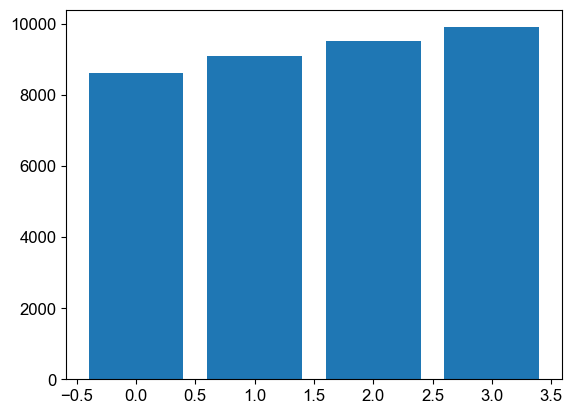

In [124]:
fig, ax = plt.subplots()

bars = [inv['num'].median() for inv in invaders]

ax.bar(range(4), bars);

**Invading**

In [165]:
files = ['../src/evolution_simulations/Invading/sdim_4_invasions_by_p1_1_p2_0.05_p3_0.6_p4_0.3.csv',
          '../src/evolution_simulations/Invading/sdim_4_invasions_by_p1_1_p2_0.6_p3_0.05_p4_0.3.csv',
 '../src/evolution_simulations/Invading/sdim_4_invasions_by_p1_1_p2_0.05_p3_0.6_p4_0.1.csv',
 '../src/evolution_simulations/Invading/sdim_4_invasions_by_p1_1_p2_0.6_p3_0.05_p4_0.1.csv']

In [166]:
invading = [pd.read_csv(file, names = ['p1', 'p2', 'p3', 'p4', 'i', 'coop', 'invaded']) for file in files]

In [167]:
[inv['invaded'].sum() for inv in invading]

[42, 41, 58, 55]

In [168]:
invading[0]['invaded'].count()

1001

In [169]:
invading[0]

,p1,p2,p3,p4,i,coop,invaded
0,1.000000,0.050000,0.600000,0.300000,0,0.000000,0
1,0.417022,0.720324,0.000114,0.302333,1,0.341830,0
2,0.092339,0.186260,0.345561,0.396767,2,0.311079,0
3,0.419195,0.685219,0.204452,0.878117,3,0.531695,1
4,0.670468,0.417305,0.558690,0.140387,4,0.372193,0
...,...,...,...,...,...,...,...
996,0.489336,0.486921,0.570292,0.544508,996,0.521569,0
997,0.884385,0.783719,0.322727,0.784437,997,0.753446,0
998,0.860226,0.773000,0.775967,0.528699,998,0.824991,0
999,0.226631,0.808678,0.965929,0.543532,999,0.589865,0
